# Further Feature Engineering & Model Comparison

**Objective:** Compare citation-impact prediction with and without LLM-extracted features.

1. **Baseline models** — Logistic Regression & XGBoost on engineered features (no embeddings)
2. **LLM feature extraction** — Score a stratified 3k/1k subset with `gpt-5-nano`
3. **Augmented model** — Combine original + LLM features, compare XGBoost performance

**Data source:** Parquet files from `./splits/` generated by `semantic_embedding_clean.ipynb`

---
## Setup

In [68]:
import os
import re
import json
import time
import hashlib
import asyncio
import numpy as np
import pandas as pd
import httpx
import nest_asyncio

from dotenv import load_dotenv
from openai import AsyncOpenAI, RateLimitError, APIConnectionError, APITimeoutError
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

SEED = 42
np.random.seed(SEED)

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(f"API key loaded: {'yes' if OPENAI_API_KEY else 'NO — set OPENAI_API_KEY in .env'}")

API key loaded: yes


---
## Section 1 — Load Data

In [69]:
SPLITS_DIR = "./splits"

X_train = pd.read_parquet(os.path.join(SPLITS_DIR, "X_train_wo_emb.parquet"))
X_test  = pd.read_parquet(os.path.join(SPLITS_DIR, "X_test_wo_emb.parquet"))
y_train = pd.read_parquet(os.path.join(SPLITS_DIR, "y_train.parquet"))["label"].values
y_test  = pd.read_parquet(os.path.join(SPLITS_DIR, "y_test.parquet"))["label"].values

# Load texts (saved by Section 2 of semantic_embedding_clean)
train_texts = pd.read_parquet(os.path.join(SPLITS_DIR, "train_texts.parquet"))["text"]
test_texts  = pd.read_parquet(os.path.join(SPLITS_DIR, "test_texts.parquet"))["text"]

print(f"X_train: {X_train.shape}  X_test: {X_test.shape}")
print(f"y_train distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"train_texts: {len(train_texts)}  test_texts: {len(test_texts)}")

X_train: (41164, 183)  X_test: (10291, 183)
y_train distribution: {0: 37134, 1: 2202, 2: 1828}
train_texts: 41164  test_texts: 10291


---
## Section 2 — Baseline Models (Full Data)

In [71]:
def compute_sample_weights(y):
    """Compute balanced sample weights for class imbalance."""
    classes = np.array(sorted(np.unique(y)))
    cw = compute_class_weight("balanced", classes=classes, y=y)
    cw_dict = dict(zip(classes, cw))
    return np.array([cw_dict[int(i)] for i in y], dtype=np.float32)


def evaluate_model(y_true, y_pred, desc=""):
    """Print macro F1, accuracy, and classification report."""
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{'='*50}")
    print(f"{desc}")
    print(f"Macro F1: {f1:.4f}  |  Accuracy: {acc:.4f}")
    print(f"{'='*50}")
    print(classification_report(y_true, y_pred, target_names=["low", "mid", "high"]))

### 2.1 — Logistic Regression Baseline

In [72]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1,
)
lr.fit(X_train.values, y_train)
y_pred_lr = lr.predict(X_test.values)

evaluate_model(y_test, y_pred_lr, "Logistic Regression (full data, no embeddings)")

/Users/jeffersonqiu/Desktop/projects/bcg_learning/ai_paper_summarizer/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



Logistic Regression (full data, no embeddings)
Macro F1: 0.3804  |  Accuracy: 0.6421
              precision    recall  f1-score   support

         low       0.96      0.67      0.79      9284
         mid       0.07      0.28      0.12       550
        high       0.15      0.59      0.24       457

    accuracy                           0.64     10291
   macro avg       0.40      0.51      0.38     10291
weighted avg       0.88      0.64      0.73     10291



/Users/jeffersonqiu/Desktop/projects/bcg_learning/ai_paper_summarizer/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.2 — XGBoost Baseline

In [73]:
sample_w = compute_sample_weights(y_train)

xgb_base = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=900,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_lambda=2.0,
    random_state=SEED,
    n_jobs=-1,
)
xgb_base.fit(X_train.values, y_train, sample_weight=sample_w)
y_pred_xgb = xgb_base.predict(X_test.values)

evaluate_model(y_test, y_pred_xgb, "XGBoost (full data, no embeddings)")


XGBoost (full data, no embeddings)
Macro F1: 0.4589  |  Accuracy: 0.8553
              precision    recall  f1-score   support

         low       0.94      0.92      0.93      9284
         mid       0.13      0.13      0.13       550
        high       0.28      0.37      0.32       457

    accuracy                           0.86     10291
   macro avg       0.45      0.47      0.46     10291
weighted avg       0.86      0.86      0.86     10291



---
## Section 3 — LLM Feature Extraction

Score a **stratified subset** (1000 per class → 3k train, proportional → ~1k test)
using `gpt-5-nano`. Results are saved incrementally to JSONL cache files so the
process is **resumable** — if interrupted, just re-run this cell.

LLM features per paper:
- 5 scores: `impact`, `novelty`, `technical_depth`, `clarity`, `adoption_likelihood` (0–5)
- 8 flags: `has_code_link`, `has_dataset`, `has_benchmark`, etc. (0/1)
- 1 categorical: `paper_type`

### 3.1 — Create & Save Stratified Subset

In [74]:
SUBSET_DIR = "./splits/llm_subset"
os.makedirs(SUBSET_DIR, exist_ok=True)

N_TRAIN_PER_CLASS = 1000  # → 3k total
N_TEST_TOTAL = 1000

# ── Load existing subset if available, otherwise create new ──
idx_train_path = os.path.join(SUBSET_DIR, "train_subset_idx.npy")
idx_test_path  = os.path.join(SUBSET_DIR, "test_subset_idx.npy")

if os.path.exists(idx_train_path) and os.path.exists(idx_test_path):
    # Reuse existing subset for reproducibility and cache compatibility
    train_subset_idx = np.load(idx_train_path)
    test_subset_idx  = np.load(idx_test_path)
    print("Loaded EXISTING subset indices from disk.")
else:
    # Create new stratified subset
    print("Creating NEW stratified subset...")
    y_train_s = pd.Series(y_train)
    train_subset_idx = []
    for cls in sorted(y_train_s.unique()):
        cls_idx = y_train_s[y_train_s == cls].index.tolist()
        sampled = np.random.choice(cls_idx, size=min(N_TRAIN_PER_CLASS, len(cls_idx)), replace=False)
        train_subset_idx.extend(sampled)
    train_subset_idx = np.sort(train_subset_idx)

    y_test_s = pd.Series(y_test)
    test_subset_idx = []
    class_counts = y_test_s.value_counts()
    for cls in sorted(y_test_s.unique()):
        n_cls = int(round(N_TEST_TOTAL * class_counts[cls] / len(y_test_s)))
        cls_idx = y_test_s[y_test_s == cls].index.tolist()
        sampled = np.random.choice(cls_idx, size=min(n_cls, len(cls_idx)), replace=False)
        test_subset_idx.extend(sampled)
    test_subset_idx = np.sort(test_subset_idx)

    np.save(idx_train_path, train_subset_idx)
    np.save(idx_test_path, test_subset_idx)

# Build subset DataFrames
X_train_sub = X_train.iloc[train_subset_idx].reset_index(drop=True)
X_test_sub  = X_test.iloc[test_subset_idx].reset_index(drop=True)
y_train_sub = y_train[train_subset_idx]
y_test_sub  = y_test[test_subset_idx]
train_texts_sub = train_texts.iloc[train_subset_idx].reset_index(drop=True)
test_texts_sub  = test_texts.iloc[test_subset_idx].reset_index(drop=True)

# Save full subset data (overwrite is fine — same indices)
X_train_sub.to_parquet(os.path.join(SUBSET_DIR, "X_train_sub.parquet"), engine="fastparquet", index=False)
X_test_sub.to_parquet(os.path.join(SUBSET_DIR, "X_test_sub.parquet"),   engine="fastparquet", index=False)
pd.DataFrame({"label": y_train_sub}).to_parquet(os.path.join(SUBSET_DIR, "y_train_sub.parquet"), engine="fastparquet", index=False)
pd.DataFrame({"label": y_test_sub}).to_parquet(os.path.join(SUBSET_DIR, "y_test_sub.parquet"),   engine="fastparquet", index=False)
pd.DataFrame({"text": train_texts_sub}).to_parquet(os.path.join(SUBSET_DIR, "train_texts_sub.parquet"), engine="pyarrow", index=False)
pd.DataFrame({"text": test_texts_sub}).to_parquet(os.path.join(SUBSET_DIR, "test_texts_sub.parquet"),   engine="pyarrow", index=False)

print(f"Train subset: {len(train_subset_idx)} rows")
print(f"  Class dist: {pd.Series(y_train_sub).value_counts().sort_index().to_dict()}")
print(f"Test  subset: {len(test_subset_idx)} rows")
print(f"  Class dist: {pd.Series(y_test_sub).value_counts().sort_index().to_dict()}")
print(f"Subset dir: {SUBSET_DIR}/")


Loaded EXISTING subset indices from disk.
Train subset: 3000 rows
  Class dist: {0: 1000, 1: 1000, 2: 1000}
Test  subset: 999 rows
  Class dist: {0: 902, 1: 53, 2: 44}
Subset dir: ./splits/llm_subset/


### 3.2 — LLM Scoring Utilities

In [75]:
MODEL_NAME = "gpt-5-nano"
LLM_CACHE_DIR = "./llm_score_cache"
os.makedirs(LLM_CACHE_DIR, exist_ok=True)

SCORE_KEYS = ["impact", "novelty", "technical_depth", "clarity", "adoption_likelihood"]
FLAG_KEYS = [
    "has_code_link", "has_dataset", "has_benchmark", "has_sota_claim",
    "has_theory", "has_large_scale_eval", "has_math", "has_released_artifacts",
]
PAPER_TYPES = ["survey", "system", "dataset", "theory", "benchmark", "application", "method", "other"]


def _stable_hash(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()


def shorten_text(text: str, max_chars: int = 800) -> str:
    return text[:max_chars] if len(text) > max_chars else text


def load_jsonl_cache(path: str) -> dict:
    cache = {}
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                rec = json.loads(line)
                cache[rec["key"]] = rec["value"]
    return cache


def append_jsonl(path: str, record: dict):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(record, ensure_ascii=False) + "\n")


_JSON_FENCE_RE = re.compile(r"```(?:json)?\s*(\{.*?\})\s*```", re.DOTALL)
_JSON_OBJ_RE  = re.compile(r"(\{.*\})", re.DOTALL)


def parse_json_strictish(s: str) -> dict:
    s = (s or "").strip()
    try:
        return json.loads(s)
    except Exception:
        pass
    m = _JSON_FENCE_RE.search(s)
    if m:
        return json.loads(m.group(1))
    m = _JSON_OBJ_RE.search(s)
    if m:
        return json.loads(m.group(1))
    raise json.JSONDecodeError("Could not find valid JSON object", s, 0)


def normalize_value(data: dict) -> dict:
    out = {}
    scores = data.get("scores", {})
    for k in SCORE_KEYS:
        out[k] = max(0, min(5, int(scores.get(k, 0))))
    flags = data.get("flags", {})
    for k in FLAG_KEYS:
        out[k] = 1 if int(flags.get(k, 0)) else 0
    pt = str(data.get("paper_type", "other")).strip().lower()
    out["paper_type"] = pt if pt in PAPER_TYPES else "other"
    return out


def make_prompt(text: str) -> str:
    return f"""Return STRICT JSON ONLY (no markdown, no backticks).

Score the paper using ONLY title+abstract text. No browsing.
Do NOT use citation counts or external info.

Schema (exact):
{{
  "scores": {{
    "impact": 0-5,
    "novelty": 0-5,
    "technical_depth": 0-5,
    "clarity": 0-5,
    "adoption_likelihood": 0-5
  }},
  "flags": {{
    "has_code_link": 0|1,
    "has_dataset": 0|1,
    "has_benchmark": 0|1,
    "has_sota_claim": 0|1,
    "has_theory": 0|1,
    "has_large_scale_eval": 0|1,
    "has_math": 0|1,
    "has_released_artifacts": 0|1
  }},
  "paper_type": "survey|system|dataset|theory|benchmark|application|method|other"
}}

Text:
{text}"""

print("LLM scoring utilities loaded.")

LLM scoring utilities loaded.


### 3.3 — Run LLM Scoring (resumable)

Each scored paper is appended to the JSONL cache immediately.
If this cell is interrupted and re-run, it picks up where it left off.

In [76]:
MAX_CHARS = 2000
CONCURRENCY = 12


async def score_one(client, model, key, text, semaphore, max_attempts=6):
    """Score a single text with retries and exponential backoff."""
    for attempt in range(1, max_attempts + 1):
        try:
            async with semaphore:
                resp = await client.responses.create(
                    model=model, input=make_prompt(text),
                )
            raw = getattr(resp, "output_text", None) or str(resp)
            return normalize_value(parse_json_strictish(raw))
        except (RateLimitError,) as e:
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except (APIConnectionError, APITimeoutError, httpx.ReadTimeout, httpx.ConnectTimeout) as e:
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except Exception as e:
            await asyncio.sleep(min(30, (1.5 ** attempt) + np.random.rand()))
    return normalize_value({})  # fallback zeros


async def score_texts_async(texts: pd.Series, cache_path: str):
    """Score all texts, skipping those already in cache. Saves incrementally."""
    cache = load_jsonl_cache(cache_path)
    print(f"Cache: {len(cache)} existing entries in {os.path.basename(cache_path)}")

    # Find texts that still need scoring
    pending = []
    for idx, t in texts.items():
        raw = "" if pd.isna(t) else str(t)
        short = shorten_text(raw, max_chars=MAX_CHARS)
        key = _stable_hash(short)
        if key not in cache:
            pending.append((idx, key, short))

    total = len(pending)
    print(f"Need scoring: {total} / {len(texts)} (skipping {len(texts) - total} cached)")

    if total == 0:
        print("All texts already scored!")
    else:
        timeout = httpx.Timeout(connect=20.0, read=60.0, write=20.0, pool=20.0)
        client = AsyncOpenAI(api_key=OPENAI_API_KEY, timeout=timeout, max_retries=0)
        semaphore = asyncio.Semaphore(CONCURRENCY)

        async def worker(idx, key, text):
            val = await score_one(client, MODEL_NAME, key, text, semaphore)
            return idx, key, val

        tasks = [asyncio.create_task(worker(i, k, t)) for (i, k, t) in pending]
        t0, done = time.time(), 0
        for task in asyncio.as_completed(tasks):
            idx, key, val = await task
            cache[key] = val
            append_jsonl(cache_path, {"key": key, "value": val})
            done += 1
            if done % 50 == 0 or done == total:
                elapsed = time.time() - t0
                rate = done / elapsed if elapsed > 0 else 0.0
                eta = ((total - done) / rate) / 60 if rate > 1e-9 else float("inf")
                print(f"  scored {done}/{total} | {rate:.1f}/s | ETA {eta:.1f} min")
        await client.close()

    # Build result DataFrame aligned to input texts
    rows = []
    for idx, t in texts.items():
        raw = "" if pd.isna(t) else str(t)
        short = shorten_text(raw, max_chars=MAX_CHARS)
        key = _stable_hash(short)
        val = cache.get(key, normalize_value({}))
        row = {k: val.get(k, 0) for k in (SCORE_KEYS + FLAG_KEYS)}
        row["paper_type"] = val.get("paper_type", "other")
        rows.append(row)
    return pd.DataFrame(rows, index=texts.index)


def score_texts(texts: pd.Series, cache_path: str) -> pd.DataFrame:
    """Synchronous wrapper — handles Jupyter's running event loop."""
    coro = score_texts_async(texts, cache_path)
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:
        loop = None
    if loop and loop.is_running():
        nest_asyncio.apply()
        return loop.run_until_complete(coro)
    else:
        return asyncio.run(coro)


# --- Score train subset ---
TRAIN_CACHE = os.path.join(LLM_CACHE_DIR, "train_subset_3k_gpt5nano_v2.jsonl")
TEST_CACHE  = os.path.join(LLM_CACHE_DIR, "test_subset_1k_gpt5nano_v2.jsonl")

print("=== Scoring TRAIN subset ===")
train_llm = score_texts(train_texts_sub, TRAIN_CACHE)

print("\n=== Scoring TEST subset ===")
test_llm = score_texts(test_texts_sub, TEST_CACHE)

=== Scoring TRAIN subset ===
Cache: 0 existing entries in train_subset_3k_gpt5nano_v2.jsonl
Need scoring: 3000 / 3000 (skipping 0 cached)
  scored 50/3000 | 0.8/s | ETA 58.8 min
  scored 100/3000 | 0.9/s | ETA 52.2 min
  scored 150/3000 | 1.0/s | ETA 50.0 min
  scored 200/3000 | 1.0/s | ETA 48.3 min
  scored 250/3000 | 1.0/s | ETA 47.1 min
  scored 300/3000 | 1.0/s | ETA 46.1 min
  scored 350/3000 | 1.0/s | ETA 45.5 min
  scored 400/3000 | 1.0/s | ETA 44.9 min
  scored 450/3000 | 1.0/s | ETA 43.5 min
  scored 500/3000 | 1.0/s | ETA 42.6 min
  scored 550/3000 | 1.0/s | ETA 41.4 min
  scored 600/3000 | 1.0/s | ETA 40.3 min
  scored 650/3000 | 1.0/s | ETA 39.7 min
  scored 700/3000 | 1.0/s | ETA 38.8 min
  scored 750/3000 | 1.0/s | ETA 38.0 min
  scored 800/3000 | 1.0/s | ETA 37.1 min
  scored 850/3000 | 1.0/s | ETA 36.1 min
  scored 900/3000 | 1.0/s | ETA 35.1 min
  scored 950/3000 | 1.0/s | ETA 34.4 min
  scored 1000/3000 | 1.0/s | ETA 33.4 min
  scored 1050/3000 | 1.0/s | ETA 32.6 min


In [77]:
# Sanity check
print("Train LLM scores sample:")
display(train_llm.head())
print(f"\nScore means:\n{train_llm[SCORE_KEYS].mean().round(2)}")
print(f"\nFlag means:\n{train_llm[FLAG_KEYS].mean().round(3)}")
print(f"\npaper_type distribution:\n{train_llm['paper_type'].value_counts()}")

Train LLM scores sample:


,impact,novelty,technical_depth,clarity,adoption_likelihood,has_code_link,has_dataset,has_benchmark,has_sota_claim,has_theory,has_large_scale_eval,has_math,has_released_artifacts,paper_type
0,4,4,4,4,4,1,0,0,1,0,0,0,1,method
1,3,4,3,4,3,0,0,1,0,1,0,1,0,method
2,4,3,4,5,4,0,0,1,0,0,0,0,0,benchmark
3,3,4,3,4,3,0,0,1,0,0,0,0,0,method
4,4,4,4,4,3,0,1,1,0,0,0,0,0,benchmark



Score means:
impact                 3.93
novelty                3.98
technical_depth        3.79
clarity                3.99
adoption_likelihood    3.49
dtype: float64

Flag means:
has_code_link             0.231
has_dataset               0.282
has_benchmark             0.417
has_sota_claim            0.390
has_theory                0.174
has_large_scale_eval      0.179
has_math                  0.128
has_released_artifacts    0.284
dtype: float64

paper_type distribution:
paper_type
method         1999
system          334
benchmark       296
survey          206
dataset          76
theory           68
application      15
other             6
Name: count, dtype: int64


---
## Section 4 — Combine Features & Compare Models

Compare XGBoost on the **same subset** with:
- **Baseline**: original engineered features only
- **Augmented**: original features + LLM scores + LLM flags + paper_type (one-hot)

In [78]:
# ── Prepare LLM numerical features ──
llm_num_cols = SCORE_KEYS + FLAG_KEYS
X_train_llm_num = train_llm[llm_num_cols].to_numpy(dtype=np.float32)
X_test_llm_num  = test_llm[llm_num_cols].to_numpy(dtype=np.float32)

# ── One-hot encode paper_type ──
ohe_pt = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_llm_type = ohe_pt.fit_transform(train_llm[["paper_type"]]).astype(np.float32)
X_test_llm_type  = ohe_pt.transform(test_llm[["paper_type"]]).astype(np.float32)
pt_col_names = list(ohe_pt.get_feature_names_out(["paper_type"]))

# ── Combine: original + LLM features ──
X_train_aug = np.hstack([X_train_sub.values, X_train_llm_num, X_train_llm_type])
X_test_aug  = np.hstack([X_test_sub.values,  X_test_llm_num,  X_test_llm_type])

aug_col_names = list(X_train_sub.columns) + llm_num_cols + pt_col_names
print(f"Original features: {X_train_sub.shape[1]}")
print(f"LLM features:      {X_train_llm_num.shape[1] + X_train_llm_type.shape[1]} ({len(llm_num_cols)} num + {len(pt_col_names)} OHE)")
print(f"Augmented total:   {X_train_aug.shape[1]}")

Original features: 183
LLM features:      21 (13 num + 8 OHE)
Augmented total:   204


### 4.1 — XGBoost on Subset: Baseline vs Augmented

In [ ]:
def train_and_eval_xgb(X_tr, X_te, y_tr, y_te, desc=""):
    """Train XGBoost with balanced weights and evaluate."""
    sw = compute_sample_weights(y_tr)
    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        n_estimators=900,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.7,
        min_child_weight=3,
        gamma=1,
        reg_lambda=2.0,
        random_state=SEED,
        n_jobs=-1,
    )
    clf.fit(X_tr, y_tr, sample_weight=sw)
    y_pred = clf.predict(X_te)
    evaluate_model(y_te, y_pred, desc)
    return clf, y_pred


print("\n" + "#" * 60)
print("# COMPARISON ON SUBSET")
print("#" * 60)

# Baseline (subset, original features only)
clf_base_sub, _ = train_and_eval_xgb(
    X_train_sub.values, X_test_sub.values, y_train_sub, y_test_sub,
    desc="XGBoost BASELINE (subset, original features only)",
)

# Augmented (subset, original + LLM features)
clf_aug, _ = train_and_eval_xgb(
    X_train_aug, X_test_aug, y_train_sub, y_test_sub,
    desc="XGBoost AUGMENTED (subset, original + LLM features)",
)


############################################################
# COMPARISON ON SUBSET
############################################################

XGBoost BASELINE (subset, original features only)
Macro F1: 0.3704  |  Accuracy: 0.6096
              precision    recall  f1-score   support

         low       0.96      0.63      0.76       902
         mid       0.07      0.34      0.12        53
        high       0.15      0.55      0.23        44

    accuracy                           0.61       999
   macro avg       0.39      0.50      0.37       999
weighted avg       0.88      0.61      0.70       999


XGBoost AUGMENTED (subset, original + LLM features)
Macro F1: 0.3742  |  Accuracy: 0.6196
              precision    recall  f1-score   support

         low       0.97      0.64      0.77       902
         mid       0.08      0.34      0.12        53
        high       0.14      0.55      0.23        44

    accuracy                           0.62       999
   macro avg       0.

### 4.2 — Feature Importance (Augmented Model)

In [90]:
importances = clf_aug.feature_importances_
feat_imp = pd.DataFrame({"feature": aug_col_names, "importance": importances})
feat_imp_all = feat_imp.sort_values("importance", ascending=False)

In [91]:
feat_imp_all.head(50)

,feature,importance
19,has_many_authors_ge5,0.055637
20,has_many_authors_ge10,0.047600
58,log_num_authors,0.030952
46,mentions_llm,0.027282
2,num_authors,0.025453
16,num_authors_offline,0.020555
50,mentions_rl,0.015862
201,paper_type_survey,0.014084
41,is_survey,0.013943
14,primary_is_cs,0.012956


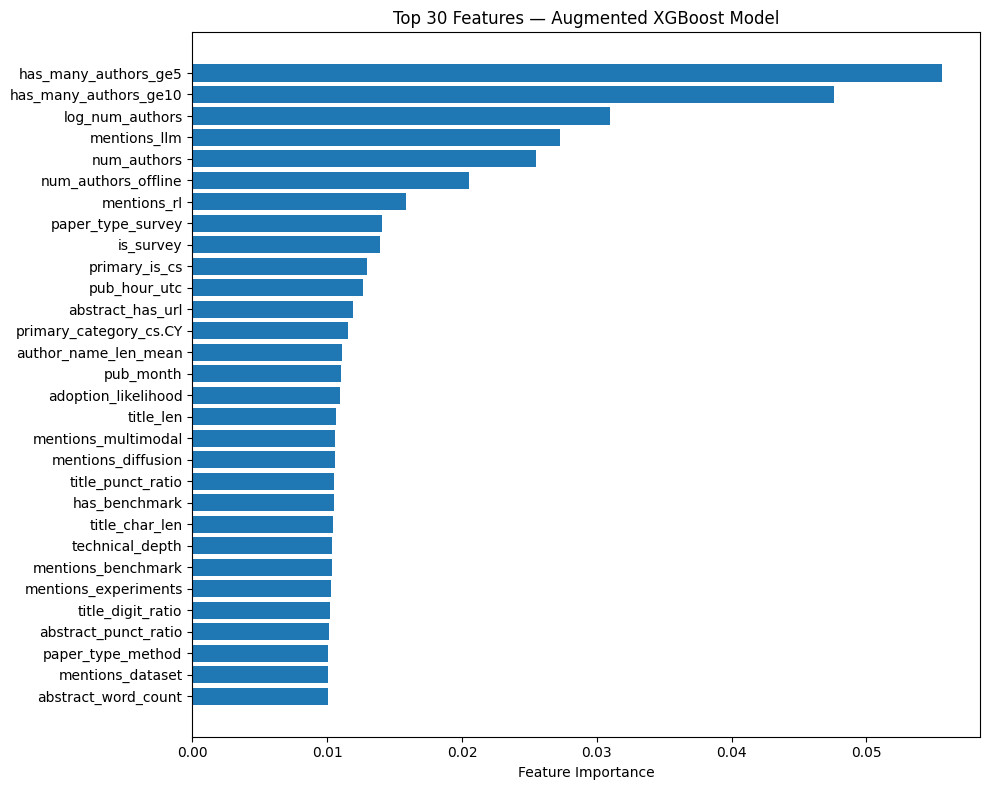


LLM features in top 30: 5


,feature,importance
201,paper_type_survey,0.014084
187,adoption_likelihood,0.010927
190,has_benchmark,0.010529
185,technical_depth,0.010357
199,paper_type_method,0.010074


In [89]:
import matplotlib.pyplot as plt

importances = clf_aug.feature_importances_
feat_imp = pd.DataFrame({"feature": aug_col_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(30)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
ax.set_xlabel("Feature Importance")
ax.set_title("Top 30 Features — Augmented XGBoost Model")
plt.tight_layout()
plt.show()

# Highlight LLM features
# Use position-based names to avoid collisions (has_math, has_theory exist in both original & LLM)
n_orig = X_train_sub.shape[1]
llm_feat_names = set(aug_col_names[n_orig:])
llm_feats = feat_imp[feat_imp["feature"].isin(llm_feat_names)]
print(f"\nLLM features in top 30: {len(llm_feats)}")
display(llm_feats)

### 4.3 — Results Summary

In [81]:
# ── Apples-to-apples comparison using WEIGHTED metrics ──
# The test subset may have a different class distribution than the full
# test set. We weight each sample so that the effective class distribution
# matches the full test set, making metrics directly comparable.

# Compute per-sample weights: weight = (full_class_proportion / subset_class_proportion)
full_dist  = pd.Series(y_test).value_counts(normalize=True).sort_index()
sub_dist   = pd.Series(y_test_sub).value_counts(normalize=True).sort_index()
class_weight_ratio = (full_dist / sub_dist).to_dict()
test_sub_weights = np.array([class_weight_ratio[int(y)] for y in y_test_sub], dtype=np.float64)

print("Class distribution comparison:")
dist_df = pd.DataFrame({"Full test": full_dist, "Subset test": sub_dist, "Weight": full_dist / sub_dist}).round(4)
display(dist_df)


def weighted_f1(y_true, y_pred, weights):
    """Compute weighted macro F1 — each class's F1 is weighted by full-data proportion."""
    classes = np.unique(y_true)
    class_f1s = []
    class_weights = []
    for cls in classes:
        mask = y_true == cls
        # Binary F1 for this class (one-vs-rest)
        tp = ((y_pred == cls) & (y_true == cls)).sum()
        fp = ((y_pred == cls) & (y_true != cls)).sum()
        fn = ((y_pred != cls) & (y_true == cls)).sum()
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        class_f1s.append(f1)
        class_weights.append(full_dist.get(cls, 1.0))
    class_weights = np.array(class_weights)
    class_weights = class_weights / class_weights.sum()
    return np.dot(class_f1s, class_weights)


def weighted_accuracy(y_true, y_pred, weights):
    """Accuracy weighted by class-rebalancing weights."""
    correct = (y_true == y_pred).astype(float)
    return np.dot(correct, weights) / weights.sum()


# Predict all models on the SAME test subset
y_pred_lr_sub      = lr.predict(X_test_sub.values)
y_pred_xgb_sub     = xgb_base.predict(X_test_sub.values)
y_pred_sub_base    = clf_base_sub.predict(X_test_sub.values)
y_pred_sub_aug     = clf_aug.predict(X_test_aug)

models = [
    ("LR (full-data train)",      y_pred_lr_sub),
    ("XGB (full-data train)",     y_pred_xgb_sub),
    ("XGB (subset train)",        y_pred_sub_base),
    ("XGB + LLM (subset train)",  y_pred_sub_aug),
]

rows = []
for name, y_pred in models:
    rows.append({
        "Model": name,
        "Weighted Macro F1": round(weighted_f1(y_test_sub, y_pred, test_sub_weights), 4),
        "Weighted Accuracy": round(weighted_accuracy(y_test_sub, y_pred, test_sub_weights), 4),
        "Raw Macro F1":      round(f1_score(y_test_sub, y_pred, average="macro"), 4),
        "Raw Accuracy":      round(accuracy_score(y_test_sub, y_pred), 4),
    })

results = pd.DataFrame(rows)

print("\n" + "=" * 70)
print("RESULTS SUMMARY (all on same test subset, weighted to full distribution)")
print("=" * 70)
display(results)


Class distribution comparison:


,Full test,Subset test,Weight
0,0.9021,0.9029,0.9992
1,0.0534,0.0531,1.0074
2,0.0444,0.0440,1.0083



RESULTS SUMMARY (all on same test subset, weighted to full distribution)


,Model,Weighted Macro F1,Weighted Accuracy,Raw Macro F1,Raw Accuracy
0,LR (full-data train),0.7226,0.6344,0.3732,0.6346
1,XGB (full-data train),0.8438,0.8343,0.4171,0.8348
2,XGB (subset train),0.7032,0.6095,0.3704,0.6096
3,XGB + LLM (subset train),0.7126,0.6195,0.3742,0.6196


---
## Section 5 — Feature Deduplication & Retrain

Many original features are **semantically redundant** (same concept measured differently),
which dilutes feature importance and may hurt model performance.

We identify correlated/duplicate feature groups, keep one representative per group,
drop the rest, and retrain to see if:
1. Overall performance improves with cleaner features
2. LLM features gain more relative importance

In [92]:
# ── Define redundant feature groups ──
# For each group: keep the best representative, drop the rest

DROP_FEATURES = {
    # --- Author count (5 features → keep log_num_authors) ---
    "num_authors":          "redundant with log_num_authors",
    "num_authors_offline":  "redundant with log_num_authors",
    "has_many_authors_ge5":  "redundant with log_num_authors",
    "has_many_authors_ge10": "redundant with log_num_authors",

    # --- Title length (3 features → keep title_word_count) ---
    "title_len":      "redundant with title_word_count",
    "title_char_len": "redundant with title_word_count",

    # --- Abstract length (4 features → keep log_abstract_word_count) ---
    "abstract_len":        "redundant with log_abstract_word_count",
    "abstract_char_len":   "redundant with log_abstract_word_count",
    "abstract_word_count": "redundant with log_abstract_word_count",

    # --- Code/open-source signals (3 features → keep mentions_github) ---
    "mentions_code":        "redundant with mentions_github",
    "mentions_open_source": "redundant with mentions_github",
}

# Show what we're dropping
print(f"Dropping {len(DROP_FEATURES)} redundant features:")
for feat, reason in DROP_FEATURES.items():
    print(f"  ✕ {feat:30s} → {reason}")

# ── Build cleaned feature sets ──
keep_mask = [c not in DROP_FEATURES for c in X_train_sub.columns]
clean_col_names = [c for c in X_train_sub.columns if c not in DROP_FEATURES]

X_train_clean = X_train_sub.loc[:, keep_mask].copy()
X_test_clean  = X_test_sub.loc[:, keep_mask].copy()

print(f"\nOriginal features: {X_train_sub.shape[1]} → Cleaned: {X_train_clean.shape[1]}")
print(f"Dropped: {X_train_sub.shape[1] - X_train_clean.shape[1]} features")

Dropping 11 redundant features:
  ✕ num_authors                    → redundant with log_num_authors
  ✕ num_authors_offline            → redundant with log_num_authors
  ✕ has_many_authors_ge5           → redundant with log_num_authors
  ✕ has_many_authors_ge10          → redundant with log_num_authors
  ✕ title_len                      → redundant with title_word_count
  ✕ title_char_len                 → redundant with title_word_count
  ✕ abstract_len                   → redundant with log_abstract_word_count
  ✕ abstract_char_len              → redundant with log_abstract_word_count
  ✕ abstract_word_count            → redundant with log_abstract_word_count
  ✕ mentions_code                  → redundant with mentions_github
  ✕ mentions_open_source           → redundant with mentions_github

Original features: 183 → Cleaned: 172
Dropped: 11 features


In [93]:
# ── Augmented = cleaned original + LLM features ──
X_train_clean_aug = np.hstack([X_train_clean.values, X_train_llm_num, X_train_llm_type])
X_test_clean_aug  = np.hstack([X_test_clean.values,  X_test_llm_num,  X_test_llm_type])

clean_aug_col_names = clean_col_names + llm_num_cols + pt_col_names

print(f"Cleaned features:       {X_train_clean.shape[1]}")
print(f"LLM features:           {len(llm_num_cols) + len(pt_col_names)}")
print(f"Cleaned + augmented:    {X_train_clean_aug.shape[1]}")

Cleaned features:       172
LLM features:           21
Cleaned + augmented:    193


### 5.1 — Retrain XGBoost: Cleaned Baseline vs Cleaned + LLM

In [102]:
from sklearn.metrics import f1_score, accuracy_score

print("\n" + "#" * 60)
print("# COMPARISON ON CLEANED FEATURES")
print("#" * 60)

# Baseline: cleaned original features only
clf_clean_base, y_pred_clean_base = train_and_eval_xgb(
    X_train_clean.values, X_test_clean.values,
    y_train_sub, y_test_sub,
    desc="XGBoost BASELINE (cleaned features only)"
)
f1_clean_base  = f1_score(y_test_sub, y_pred_clean_base, average="macro")
acc_clean_base = accuracy_score(y_test_sub, y_pred_clean_base)

# Augmented: cleaned + LLM
clf_clean_aug_model, y_pred_clean_aug = train_and_eval_xgb(
    X_train_clean_aug, X_test_clean_aug,
    y_train_sub, y_test_sub,
    desc="XGBoost AUGMENTED (cleaned + LLM features)"
)
f1_clean_aug  = f1_score(y_test_sub, y_pred_clean_aug, average="macro")
acc_clean_aug = accuracy_score(y_test_sub, y_pred_clean_aug)



############################################################
# COMPARISON ON CLEANED FEATURES
############################################################

XGBoost BASELINE (cleaned features only)
Macro F1: 0.3750  |  Accuracy: 0.6126
              precision    recall  f1-score   support

         low       0.97      0.63      0.76       902
         mid       0.08      0.38      0.13        53
        high       0.15      0.52      0.23        44

    accuracy                           0.61       999
   macro avg       0.40      0.51      0.38       999
weighted avg       0.88      0.61      0.71       999


XGBoost AUGMENTED (cleaned + LLM features)
Macro F1: 0.3721  |  Accuracy: 0.6166
              precision    recall  f1-score   support

         low       0.97      0.64      0.77       902
         mid       0.06      0.28      0.10        53
        high       0.16      0.57      0.25        44

    accuracy                           0.62       999
   macro avg       0.40      

### 5.2 — Feature Importance (Cleaned + Augmented)

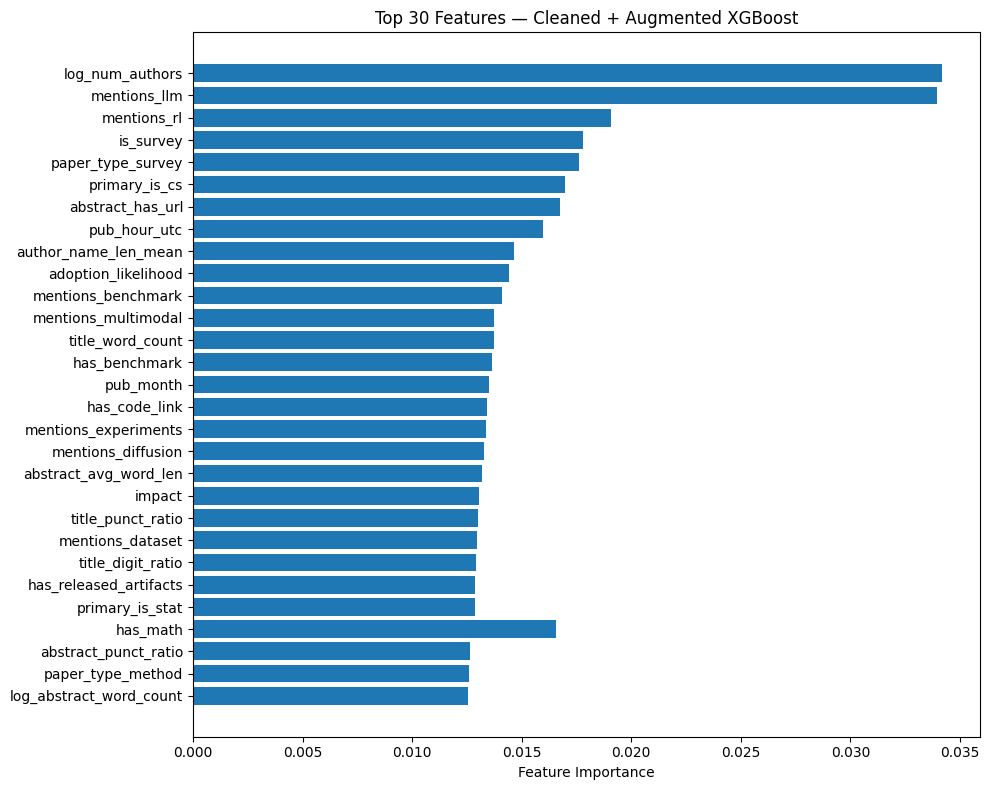


LLM features in top 30: 9


,feature,importance
190,paper_type_survey,0.017613
8,has_math,0.016558
176,adoption_likelihood,0.014435
179,has_benchmark,0.013657
177,has_code_link,0.013409
172,impact,0.013070
184,has_released_artifacts,0.012864
183,has_math,0.012748
188,paper_type_method,0.012597


In [103]:
importances_clean = clf_clean_aug_model.feature_importances_
feat_imp_clean = pd.DataFrame({"feature": clean_aug_col_names, "importance": importances_clean})
feat_imp_clean = feat_imp_clean.sort_values("importance", ascending=False).head(30)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feat_imp_clean["feature"][::-1], feat_imp_clean["importance"][::-1])
ax.set_xlabel("Feature Importance")
ax.set_title("Top 30 Features — Cleaned + Augmented XGBoost")
plt.tight_layout()
plt.show()

# Highlight LLM features
n_clean = len(clean_col_names)
llm_feat_names_clean = set(clean_aug_col_names[n_clean:])
llm_feats_clean = feat_imp_clean[feat_imp_clean["feature"].isin(llm_feat_names_clean)]
print(f"\nLLM features in top 30: {len(llm_feats_clean)}")
display(llm_feats_clean)


### 5.3 — Before vs After Deduplication

In [104]:
# ── Recompute original metrics by re-predicting ──
y_pred_base_orig = clf_base_sub.predict(X_test_sub.values)
y_pred_aug_orig  = clf_aug.predict(X_test_aug)

f1_base  = f1_score(y_test_sub, y_pred_base_orig, average="macro")
acc_base = accuracy_score(y_test_sub, y_pred_base_orig)
f1_aug   = f1_score(y_test_sub, y_pred_aug_orig, average="macro")
acc_aug  = accuracy_score(y_test_sub, y_pred_aug_orig)

comparison = pd.DataFrame([
    {"Model": "XGB baseline (original)",  "Features": X_train_sub.shape[1],      "Macro F1": round(f1_base, 4),       "Accuracy": round(acc_base, 4)},
    {"Model": "XGB + LLM (original)",      "Features": X_train_aug.shape[1],      "Macro F1": round(f1_aug, 4),        "Accuracy": round(acc_aug, 4)},
    {"Model": "XGB baseline (cleaned)",    "Features": X_train_clean.shape[1],    "Macro F1": round(f1_clean_base, 4), "Accuracy": round(acc_clean_base, 4)},
    {"Model": "XGB + LLM (cleaned)",       "Features": X_train_clean_aug.shape[1],"Macro F1": round(f1_clean_aug, 4),  "Accuracy": round(acc_clean_aug, 4)},
])

print("\n" + "=" * 70)
print("DEDUPLICATION IMPACT (all on same subset test data)")
print("=" * 70)
display(comparison)

# LLM lift comparison
lift_before = f1_aug - f1_base
lift_after  = f1_clean_aug - f1_clean_base
print(f"\nLLM lift (Macro F1):")
print(f"  Before dedup: {lift_before:+.4f} ({f1_base:.4f} → {f1_aug:.4f})")
print(f"  After dedup:  {lift_after:+.4f} ({f1_clean_base:.4f} → {f1_clean_aug:.4f})")



DEDUPLICATION IMPACT (all on same subset test data)


,Model,Features,Macro F1,Accuracy
0,XGB baseline (original),183,0.3704,0.6096
1,XGB + LLM (original),204,0.3742,0.6196
2,XGB baseline (cleaned),172,0.3750,0.6126
3,XGB + LLM (cleaned),193,0.3721,0.6166



LLM lift (Macro F1):
  Before dedup: +0.0038 (0.3704 → 0.3742)
  After dedup:  -0.0029 (0.3750 → 0.3721)


---
## Section 6 — Advanced Feature Engineering from LLM Scores

Raw LLM scores (0–5) are weak on their own because:
- They're **low-variance** (most papers score 3–4)
- They don't capture **interactions** (e.g. high impact × hot topic)
- They miss **aggregate signals** (overall quality, reproducibility)

We engineer richer features from existing LLM + original data:

| Group | Rationale |
|---|---|
| **Score interactions** | Breakthrough = impact × novelty; Practical = impact × adoption |
| **Score aggregates** | Mean, std, min/max capture overall quality + polarization |
| **Flag aggregates** | Total flags = paper completeness; reproducibility subset |
| **Cross-domain** | Quality × topic hotness (LLM × original) interactions |
| **Binary thresholds** | Non-linear splits: "high impact" (≥4) vs not |

In [105]:
def engineer_advanced_llm_features(llm_df, orig_df):
    """
    Create advanced features from LLM scores + original features.
    Returns a DataFrame of new features (aligned to input index).
    """
    out = pd.DataFrame(index=llm_df.index)

    # ── A. Score interactions (multiplicative) ──
    out["impact_x_novelty"]    = llm_df["impact"] * llm_df["novelty"]
    out["impact_x_adoption"]   = llm_df["impact"] * llm_df["adoption_likelihood"]
    out["depth_x_clarity"]     = llm_df["technical_depth"] * llm_df["clarity"]
    out["novelty_x_adoption"]  = llm_df["novelty"] * llm_df["adoption_likelihood"]
    out["impact_x_depth"]      = llm_df["impact"] * llm_df["technical_depth"]

    # ── B. Score aggregates ──
    score_cols = ["impact", "novelty", "technical_depth", "clarity", "adoption_likelihood"]
    scores = llm_df[score_cols]
    out["llm_avg_score"]  = scores.mean(axis=1)
    out["llm_score_std"]  = scores.std(axis=1)
    out["llm_max_score"]  = scores.max(axis=1)
    out["llm_min_score"]  = scores.min(axis=1)
    out["llm_score_range"] = out["llm_max_score"] - out["llm_min_score"]

    # ── C. Flag aggregates ──
    flag_cols = ["has_code_link", "has_dataset", "has_benchmark", "has_sota_claim",
                 "has_theory", "has_large_scale_eval", "has_math", "has_released_artifacts"]
    out["llm_flag_count"] = llm_df[flag_cols].sum(axis=1)
    # Reproducibility subset: code + data + benchmark + artifacts
    out["reproducibility_score"] = (
        llm_df["has_code_link"] + llm_df["has_dataset"] +
        llm_df["has_benchmark"] + llm_df["has_released_artifacts"]
    )
    # Rigor subset: benchmark + large_scale_eval + math
    out["rigor_score"] = (
        llm_df["has_benchmark"] + llm_df["has_large_scale_eval"] + llm_df["has_math"]
    )

    # ── D. Cross-domain interactions (LLM × original) ──
    # Quality × author prestige proxy
    if "log_num_authors" in orig_df.columns:
        out["impact_x_log_authors"] = llm_df["impact"] * orig_df["log_num_authors"].values
    # Quality × topic hotness
    if "mentions_llm" in orig_df.columns:
        out["impact_x_mentions_llm"] = llm_df["impact"] * orig_df["mentions_llm"].values
        out["novelty_x_mentions_llm"] = llm_df["novelty"] * orig_df["mentions_llm"].values
    if "mentions_rl" in orig_df.columns:
        out["impact_x_mentions_rl"] = llm_df["impact"] * orig_df["mentions_rl"].values
    # Quality × CS field
    if "primary_is_cs" in orig_df.columns:
        out["impact_x_is_cs"] = llm_df["impact"] * orig_df["primary_is_cs"].values
    # Adoption × code availability
    if "mentions_github" in orig_df.columns:
        out["adoption_x_github"] = llm_df["adoption_likelihood"] * orig_df["mentions_github"].values
    # Depth × abstract length (deeper analysis in longer abstracts)
    if "log_abstract_word_count" in orig_df.columns:
        out["depth_x_abstract_len"] = llm_df["technical_depth"] * orig_df["log_abstract_word_count"].values

    # ── E. Binary thresholds (non-linear splits) ──
    out["high_impact"]    = (llm_df["impact"] >= 4).astype(np.float32)
    out["high_novelty"]   = (llm_df["novelty"] >= 4).astype(np.float32)
    out["high_adoption"]  = (llm_df["adoption_likelihood"] >= 4).astype(np.float32)
    out["high_avg_score"] = (out["llm_avg_score"] >= 4.0).astype(np.float32)
    out["all_flags_zero"] = (out["llm_flag_count"] == 0).astype(np.float32)

    return out.astype(np.float32)


# ── Apply to train and test ──
adv_train = engineer_advanced_llm_features(train_llm, X_train_clean)
adv_test  = engineer_advanced_llm_features(test_llm, X_test_clean)

print(f"Advanced LLM features: {adv_train.shape[1]}")
print(f"\nNew feature names:")
for i, c in enumerate(adv_train.columns, 1):
    print(f"  {i:2d}. {c}")

print(f"\nSample stats:")
display(adv_train.describe().T[["mean", "std", "min", "max"]])

Advanced LLM features: 25

New feature names:
   1. impact_x_novelty
   2. impact_x_adoption
   3. depth_x_clarity
   4. novelty_x_adoption
   5. impact_x_depth
   6. llm_avg_score
   7. llm_score_std
   8. llm_max_score
   9. llm_min_score
  10. llm_score_range
  11. llm_flag_count
  12. reproducibility_score
  13. rigor_score
  14. impact_x_log_authors
  15. impact_x_mentions_llm
  16. novelty_x_mentions_llm
  17. impact_x_mentions_rl
  18. impact_x_is_cs
  19. adoption_x_github
  20. depth_x_abstract_len
  21. high_impact
  22. high_novelty
  23. high_adoption
  24. high_avg_score
  25. all_flags_zero

Sample stats:


,mean,std,min,max
impact_x_novelty,15.749666,3.162541,4.000000,25.000000
impact_x_adoption,13.804334,2.928522,4.000000,25.000000
depth_x_clarity,15.126000,2.623564,3.000000,25.000000
novelty_x_adoption,13.963000,3.320237,4.000000,25.000000
impact_x_depth,14.986333,3.152056,3.000000,25.000000
llm_avg_score,3.836467,0.313512,2.200000,4.800000
llm_score_std,0.404716,0.257021,0.000000,1.140175
llm_max_score,4.213333,0.414584,3.000000,5.000000
llm_min_score,3.323667,0.568930,1.000000,4.000000
llm_score_range,0.889667,0.612877,0.000000,3.000000


### 6.1 — Retrain with Advanced LLM Features

In [106]:
# ── Build final feature matrices ──
# Option A: cleaned + raw LLM + advanced LLM
X_train_v2 = np.hstack([X_train_clean.values, X_train_llm_num, X_train_llm_type, adv_train.values])
X_test_v2  = np.hstack([X_test_clean.values,  X_test_llm_num,  X_test_llm_type,  adv_test.values])
v2_col_names = clean_col_names + llm_num_cols + pt_col_names + list(adv_train.columns)

# Option B: cleaned + advanced LLM only (skip raw scores — they're captured in interactions)
X_train_v3 = np.hstack([X_train_clean.values, adv_train.values])
X_test_v3  = np.hstack([X_test_clean.values,  adv_test.values])
v3_col_names = clean_col_names + list(adv_train.columns)

print(f"Option A (cleaned + raw LLM + advanced): {X_train_v2.shape[1]} features")
print(f"Option B (cleaned + advanced only):      {X_train_v3.shape[1]} features")

print("\n" + "#" * 60)
print("# ADVANCED LLM FEATURES COMPARISON")
print("#" * 60)

# Cleaned baseline (no LLM)
_, y_pred_v0 = train_and_eval_xgb(
    X_train_clean.values, X_test_clean.values,
    y_train_sub, y_test_sub,
    desc="XGB baseline (cleaned, no LLM)"
)

# Option A: all features
clf_v2, y_pred_v2 = train_and_eval_xgb(
    X_train_v2, X_test_v2,
    y_train_sub, y_test_sub,
    desc="XGB + raw LLM + advanced (Option A)"
)

# Option B: advanced only
clf_v3, y_pred_v3 = train_and_eval_xgb(
    X_train_v3, X_test_v3,
    y_train_sub, y_test_sub,
    desc="XGB + advanced LLM only (Option B)"
)

Option A (cleaned + raw LLM + advanced): 218 features
Option B (cleaned + advanced only):      197 features

############################################################
# ADVANCED LLM FEATURES COMPARISON
############################################################

XGB baseline (cleaned, no LLM)
Macro F1: 0.3750  |  Accuracy: 0.6126
              precision    recall  f1-score   support

         low       0.97      0.63      0.76       902
         mid       0.08      0.38      0.13        53
        high       0.15      0.52      0.23        44

    accuracy                           0.61       999
   macro avg       0.40      0.51      0.38       999
weighted avg       0.88      0.61      0.71       999


XGB + raw LLM + advanced (Option A)
Macro F1: 0.3581  |  Accuracy: 0.6176
              precision    recall  f1-score   support

         low       0.97      0.65      0.77       902
         mid       0.05      0.23      0.09        53
        high       0.14      0.52      0.21  

In [107]:
# ── Final comparison table ──
from sklearn.metrics import f1_score, accuracy_score

results = pd.DataFrame([
    {"Model": "XGB baseline (cleaned)",
     "Features": X_train_clean.shape[1],
     "Macro F1": round(f1_score(y_test_sub, y_pred_v0, average='macro'), 4),
     "Accuracy": round(accuracy_score(y_test_sub, y_pred_v0), 4)},
    {"Model": "XGB + raw LLM (cleaned)",
     "Features": X_train_clean_aug.shape[1],
     "Macro F1": round(f1_clean_aug, 4),
     "Accuracy": round(acc_clean_aug, 4)},
    {"Model": "XGB + raw + advanced LLM (A)",
     "Features": X_train_v2.shape[1],
     "Macro F1": round(f1_score(y_test_sub, y_pred_v2, average='macro'), 4),
     "Accuracy": round(accuracy_score(y_test_sub, y_pred_v2), 4)},
    {"Model": "XGB + advanced LLM only (B)",
     "Features": X_train_v3.shape[1],
     "Macro F1": round(f1_score(y_test_sub, y_pred_v3, average='macro'), 4),
     "Accuracy": round(accuracy_score(y_test_sub, y_pred_v3), 4)},
])

print("\n" + "=" * 70)
print("ADVANCED LLM FEATURES — RESULTS SUMMARY")
print("=" * 70)
display(results)

# Show which advanced features matter most
print("\n--- Top features in best model (Option A) ---")
imp_v2 = pd.DataFrame({"feature": v2_col_names, "importance": clf_v2.feature_importances_})
imp_v2 = imp_v2.sort_values("importance", ascending=False)

# Mark feature source
adv_names = set(adv_train.columns)
raw_llm_names = set(llm_num_cols + pt_col_names)
imp_v2["source"] = imp_v2["feature"].apply(
    lambda f: "🔷 advanced LLM" if f in adv_names
    else ("🔵 raw LLM" if f in raw_llm_names else "⬜ original")
)
display(imp_v2.head(30))


ADVANCED LLM FEATURES — RESULTS SUMMARY


,Model,Features,Macro F1,Accuracy
0,XGB baseline (cleaned),172,0.3750,0.6126
1,XGB + raw LLM (cleaned),193,0.3721,0.6166
2,XGB + raw + advanced LLM (A),218,0.3581,0.6176
3,XGB + advanced LLM only (B),197,0.3649,0.6036



--- Top features in best model (Option A) ---


,feature,importance,source
207,impact_x_mentions_llm,0.029915,🔷 advanced LLM
206,impact_x_log_authors,0.025242,🔷 advanced LLM
47,log_num_authors,0.020739,⬜ original
36,mentions_llm,0.019475,⬜ original
209,impact_x_mentions_rl,0.015430,🔷 advanced LLM
31,is_survey,0.013921,⬜ original
190,paper_type_survey,0.013446,🔵 raw LLM
208,novelty_x_mentions_llm,0.013377,🔷 advanced LLM
40,mentions_rl,0.013344,⬜ original
11,primary_is_cs,0.013215,⬜ original


---
## Section 7 — Citation-Focused LLM Scoring (gpt-4.1-nano)

The previous LLM features asked **generic quality** questions (impact, novelty, clarity)
which don't directly predict citations. Here we redesign the prompt to ask
**citation-specific** factors:

| What changed | v1 (gpt-5-nano) | v2 (gpt-4.1-nano) |
|---|---|---|
| **Prompt focus** | Generic quality | Citation prediction |
| **Scale** | 0–5 | 0–10 (more granular) |
| **Model** | gpt-5-nano | gpt-4.1-nano (better reasoning) |
| **Key scores** | impact, novelty, clarity... | citation_potential, topic_trendiness, reusability... |
| **Direct prediction** | None | citation_tier (low/medium/high/very_high) |

### 7.1 — Citation-Focused Scoring Utilities

In [27]:
from tqdm.asyncio import tqdm_asyncio
# ── Citation-focused LLM scoring config ──
V2_MODEL = "gpt-4.1-nano"
V2_MAX_CHARS = 2000

V2_SCORE_KEYS = [
    "citation_potential",       # Direct citation likelihood estimate
    "methodological_novelty",   # How novel is the method/approach
    "practical_utility",        # How useful for practitioners/industry
    "topic_trendiness",         # How hot/trending is the research topic
    "reusability",              # Can others easily build on this work
    "community_breadth",        # How broad is the potential citing community
    "writing_accessibility",    # How accessible to non-experts
]

V2_FLAG_KEYS = [
    "introduces_framework",       # New reusable framework/library
    "new_dataset_or_benchmark",   # Creates new dataset or benchmark
    "comprehensive_survey",       # Survey/review paper
    "addresses_open_problem",     # Tackles a well-known open problem
    "strong_empirical_results",   # Strong experimental results
    "cross_disciplinary",         # Relevant across multiple fields
    "provides_theoretical_insight",# Novel theoretical contribution
]

V2_TIER_VALUES = ["very_high", "high", "medium", "low"]


def make_prompt_v2(text: str) -> str:
    return f"""Return STRICT JSON ONLY (no markdown, no backticks, no explanation).

You are an expert AI researcher. Given a paper's title and abstract,
predict its CITATION IMPACT — how likely it is to be widely cited.

Think about: Does it introduce something others will build on?
Is the topic trending? Would many communities reference this?

Schema (exact keys, no extras):
{{
  "scores": {{
    "citation_potential": 0-10,
    "methodological_novelty": 0-10,
    "practical_utility": 0-10,
    "topic_trendiness": 0-10,
    "reusability": 0-10,
    "community_breadth": 0-10,
    "writing_accessibility": 0-10
  }},
  "flags": {{
    "introduces_framework": 0|1,
    "new_dataset_or_benchmark": 0|1,
    "comprehensive_survey": 0|1,
    "addresses_open_problem": 0|1,
    "strong_empirical_results": 0|1,
    "cross_disciplinary": 0|1,
    "provides_theoretical_insight": 0|1
  }},
  "citation_tier": "very_high|high|medium|low"
}}

Scoring guide:
- 0-2: Very low / absent
- 3-4: Below average
- 5-6: Average / moderate
- 7-8: Above average / strong
- 9-10: Exceptional / top-tier

Text:
{text}"""


def normalize_value_v2(data: dict) -> dict:
    """Normalize parsed JSON into consistent feature dict."""
    out = {}
    scores = data.get("scores", {})
    for k in V2_SCORE_KEYS:
        out[k] = max(0, min(10, int(scores.get(k, 0))))
    flags = data.get("flags", {})
    for k in V2_FLAG_KEYS:
        out[k] = 1 if int(flags.get(k, 0)) else 0
    tier = str(data.get("citation_tier", "low")).strip().lower()
    out["citation_tier"] = tier if tier in V2_TIER_VALUES else "low"
    return out


# ── Scoring engine (reuses async infrastructure from Section 3) ──
async def score_one_v2(client, model, key, text, semaphore, max_attempts=6):
    """Score a single text with citation-focused prompt."""
    for attempt in range(1, max_attempts + 1):
        try:
            async with semaphore:
                resp = await client.responses.create(
                    model=model, input=make_prompt_v2(text),
                )
            raw = getattr(resp, "output_text", None) or str(resp)
            return normalize_value_v2(parse_json_strictish(raw))
        except (RateLimitError,) as e:
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except (APIConnectionError, APITimeoutError, httpx.ReadTimeout, httpx.ConnectTimeout) as e:
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except Exception as e:
            await asyncio.sleep(min(30, (1.5 ** attempt) + np.random.rand()))
    # Fallback: zeros
    out = {k: 0 for k in V2_SCORE_KEYS}
    out.update({k: 0 for k in V2_FLAG_KEYS})
    out["citation_tier"] = "low"
    return out


async def score_texts_v2_async(texts: pd.Series, cache_path: str) -> pd.DataFrame:
    """Score all texts with citation-focused prompt, using cache."""
    cache = load_jsonl_cache(cache_path)
    pending = []
    results = {}

    for idx, raw in texts.items():
        short = shorten_text(raw, max_chars=V2_MAX_CHARS)
        key = _stable_hash(short)
        if key in cache:
            results[idx] = cache[key]
        else:
            pending.append((idx, key, short))

    print(f"Cache hits: {len(results)} / {len(texts)} | To score: {len(pending)}")

    if pending:
        client = AsyncOpenAI(api_key=OPENAI_API_KEY)
        sem = asyncio.Semaphore(CONCURRENCY)
        tasks_list = [
            score_one_v2(client, V2_MODEL, key, text, sem)
            for (_, key, text) in pending
        ]
        scored = await tqdm_asyncio.gather(*tasks_list, desc=f"Scoring ({V2_MODEL})")
        for (idx, key, _), val in zip(pending, scored):
            results[idx] = val
            append_jsonl(cache_path, {"key": key, "value": val})

    print(f"Done — scored {len(texts)}/{len(texts)}")
    return pd.DataFrame.from_dict(results, orient="index").sort_index()


def score_texts_v2(texts: pd.Series, cache_path: str) -> pd.DataFrame:
    """Synchronous wrapper — handles Jupyter's running event loop."""
    coro = score_texts_v2_async(texts, cache_path)
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:
        loop = None
    if loop and loop.is_running():
        import nest_asyncio
        nest_asyncio.apply()
        return loop.run_until_complete(coro)
    else:
        return asyncio.run(coro)


print("Citation-focused scoring utilities loaded.")
print(f"Model: {V2_MODEL} | Max chars: {V2_MAX_CHARS}")
print(f"Scores: {V2_SCORE_KEYS}")
print(f"Flags:  {V2_FLAG_KEYS}")

Citation-focused scoring utilities loaded.
Model: gpt-4.1-nano | Max chars: 2000
Scores: ['citation_potential', 'methodological_novelty', 'practical_utility', 'topic_trendiness', 'reusability', 'community_breadth', 'writing_accessibility']
Flags:  ['introduces_framework', 'new_dataset_or_benchmark', 'comprehensive_survey', 'addresses_open_problem', 'strong_empirical_results', 'cross_disciplinary', 'provides_theoretical_insight']


### 7.2 — Run Citation-Focused Scoring (resumable)

Uses the **same 3k/1k subset** from Section 3. Cache is saved to separate files
so v1 scores are preserved.

In [28]:
# ── Run citation-focused scoring ──
V2_CACHE_TRAIN = os.path.join(LLM_CACHE_DIR, "train_subset_3k_gpt41nano_v1.jsonl")
V2_CACHE_TEST  = os.path.join(LLM_CACHE_DIR, "test_subset_1k_gpt41nano_v1.jsonl")

print("Scoring TRAIN subset...")
train_llm_v2 = score_texts_v2(train_texts_sub, V2_CACHE_TRAIN)

print("\nScoring TEST subset...")
test_llm_v2 = score_texts_v2(test_texts_sub, V2_CACHE_TEST)

Scoring TRAIN subset...
Cache hits: 0 / 3000 | To score: 3000


Scoring (gpt-4.1-nano): 100%|██████████| 3000/3000 [11:14<00:00,  4.45it/s]


Done — scored 3000/3000

Scoring TEST subset...
Cache hits: 0 / 999 | To score: 999


Scoring (gpt-4.1-nano): 100%|██████████| 999/999 [03:31<00:00,  4.72it/s]

Done — scored 999/999


In [29]:
# Sanity check: score distributions
print("Train v2 scores sample:")
display(train_llm_v2[V2_SCORE_KEYS].describe().T[["mean", "std", "min", "max"]])

print("\nTrain v2 flag rates:")
display(train_llm_v2[V2_FLAG_KEYS].mean().to_frame("rate").T)

print("\nCitation tier distribution (train):")
print(train_llm_v2["citation_tier"].value_counts())

# Check for all-zeros (would indicate API failures)
zero_mask = train_llm_v2[V2_SCORE_KEYS].sum(axis=1) == 0
print(f"\nAll-zero entries: {zero_mask.sum()} / {len(train_llm_v2)}")

Train v2 scores sample:


,mean,std,min,max
citation_potential,7.920000,0.519958,4.0,9.0
methodological_novelty,7.673000,0.928273,2.0,9.0
practical_utility,8.414667,0.724035,2.0,10.0
topic_trendiness,7.726333,0.782503,5.0,10.0
reusability,7.913000,0.653381,3.0,9.0
community_breadth,7.244333,0.739471,3.0,9.0
writing_accessibility,7.052000,0.683217,4.0,9.0



Train v2 flag rates:


,introduces_framework,new_dataset_or_benchmark,comprehensive_survey,addresses_open_problem,strong_empirical_results,cross_disciplinary,provides_theoretical_insight
rate,0.909667,0.353,0.067333,0.993333,0.895667,0.634,0.377667



Citation tier distribution (train):
citation_tier
high         2668
very_high     292
medium         37
low             3
Name: count, dtype: int64

All-zero entries: 0 / 3000


### 7.3 — Combine Features & Train

In [30]:
# ── Prepare v2 LLM features ──
v2_num_cols = V2_SCORE_KEYS + V2_FLAG_KEYS
X_train_v2_num = train_llm_v2[v2_num_cols].to_numpy(dtype=np.float32)
X_test_v2_num  = test_llm_v2[v2_num_cols].to_numpy(dtype=np.float32)

# One-hot encode citation_tier
ohe_tier = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_v2_tier = ohe_tier.fit_transform(train_llm_v2[["citation_tier"]]).astype(np.float32)
X_test_v2_tier  = ohe_tier.transform(test_llm_v2[["citation_tier"]]).astype(np.float32)
tier_col_names = list(ohe_tier.get_feature_names_out(["citation_tier"]))

# ── Build augmented: cleaned original + v2 LLM ──
X_train_cite = np.hstack([X_train_clean.values, X_train_v2_num, X_train_v2_tier])
X_test_cite  = np.hstack([X_test_clean.values,  X_test_v2_num,  X_test_v2_tier])
cite_col_names = clean_col_names + v2_num_cols + tier_col_names

print(f"Cleaned original features: {X_train_clean.shape[1]}")
print(f"v2 LLM features:           {len(v2_num_cols) + len(tier_col_names)}")
print(f"Total (cleaned + v2 LLM):  {X_train_cite.shape[1]}")

Cleaned original features: 172
v2 LLM features:           18
Total (cleaned + v2 LLM):  190


In [31]:
print("\n" + "#" * 60)
print("# CITATION-FOCUSED LLM FEATURES")
print("#" * 60)

# Baseline (cleaned, no LLM)
_, y_pred_cite_base = train_and_eval_xgb(
    X_train_clean.values, X_test_clean.values,
    y_train_sub, y_test_sub,
    desc="XGB baseline (cleaned, no LLM)"
)

# v2: cleaned + citation-focused LLM
clf_cite, y_pred_cite = train_and_eval_xgb(
    X_train_cite, X_test_cite,
    y_train_sub, y_test_sub,
    desc="XGB + citation-focused LLM (gpt-4.1-nano)"
)


############################################################
# CITATION-FOCUSED LLM FEATURES
############################################################

XGB baseline (cleaned, no LLM)
Macro F1: 0.3750  |  Accuracy: 0.6126
              precision    recall  f1-score   support

         low       0.97      0.63      0.76       902
         mid       0.08      0.38      0.13        53
        high       0.15      0.52      0.23        44

    accuracy                           0.61       999
   macro avg       0.40      0.51      0.38       999
weighted avg       0.88      0.61      0.71       999


XGB + citation-focused LLM (gpt-4.1-nano)
Macro F1: 0.3824  |  Accuracy: 0.6256
              precision    recall  f1-score   support

         low       0.97      0.65      0.77       902
         mid       0.07      0.30      0.11        53
        high       0.17      0.61      0.26        44

    accuracy                           0.63       999
   macro avg       0.40      0.52      0.

### 7.4 — Feature Importance & Comparison

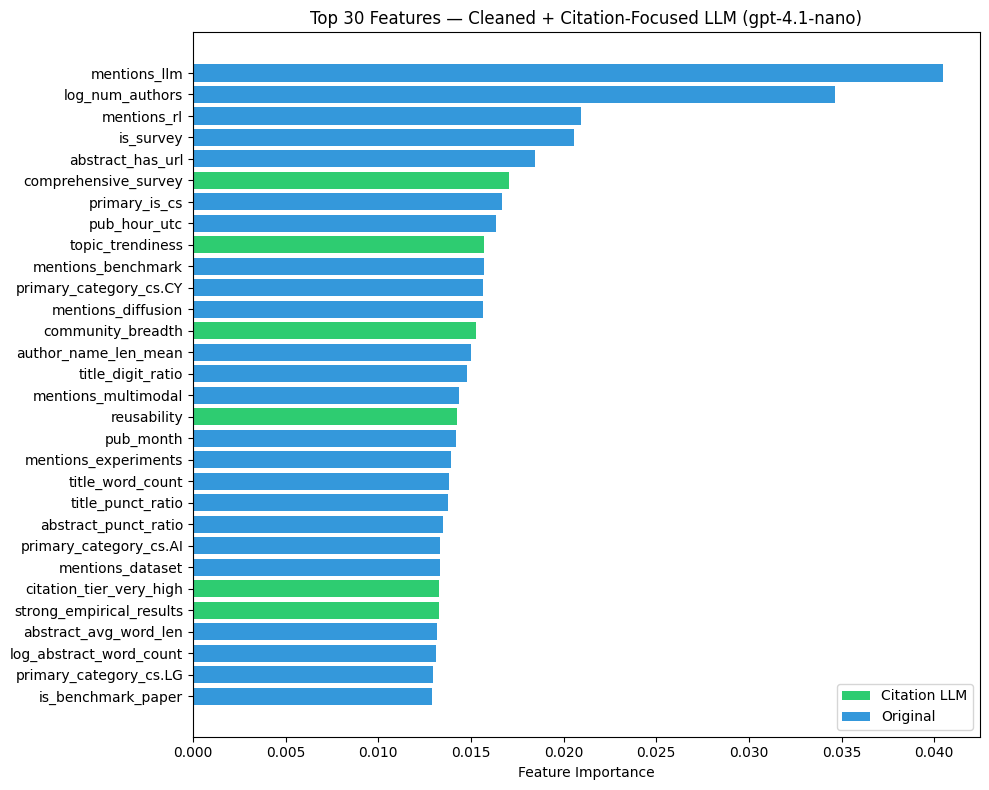


Citation LLM features in top 30: 6


,feature,importance,source
181,comprehensive_survey,0.017040,🟢 citation LLM
175,topic_trendiness,0.015712,🟢 citation LLM
177,community_breadth,0.015295,🟢 citation LLM
176,reusability,0.014245,🟢 citation LLM
189,citation_tier_very_high,0.013276,🟢 citation LLM
183,strong_empirical_results,0.013262,🟢 citation LLM


In [32]:
# ── Feature importance for citation-focused model ──
imp_cite = pd.DataFrame({"feature": cite_col_names, "importance": clf_cite.feature_importances_})
imp_cite = imp_cite.sort_values("importance", ascending=False)

# Mark source
v2_llm_names = set(v2_num_cols + tier_col_names)
imp_cite["source"] = imp_cite["feature"].apply(
    lambda f: "🟢 citation LLM" if f in v2_llm_names else "⬜ original"
)

fig, ax = plt.subplots(figsize=(10, 8))
top30 = imp_cite.head(30)
colors = ["#2ecc71" if s == "🟢 citation LLM" else "#3498db" for s in top30["source"][::-1]]
ax.barh(top30["feature"][::-1], top30["importance"][::-1], color=colors)
ax.set_xlabel("Feature Importance")
ax.set_title("Top 30 Features — Cleaned + Citation-Focused LLM (gpt-4.1-nano)")
# Legend
from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(facecolor="#2ecc71", label="Citation LLM"),
    Patch(facecolor="#3498db", label="Original"),
], loc="lower right")
plt.tight_layout()
plt.show()

# LLM features in top 30
llm_in_top30 = top30[top30["source"] == "🟢 citation LLM"]
print(f"\nCitation LLM features in top 30: {len(llm_in_top30)}")
display(llm_in_top30)

In [33]:
# ── Grand comparison: all approaches ──
from sklearn.metrics import f1_score, accuracy_score

f1_cite_base = f1_score(y_test_sub, y_pred_cite_base, average="macro")
f1_cite      = f1_score(y_test_sub, y_pred_cite, average="macro")
acc_cite_base = accuracy_score(y_test_sub, y_pred_cite_base)
acc_cite      = accuracy_score(y_test_sub, y_pred_cite)

grand_comparison = pd.DataFrame([
    {"Model": "XGB baseline (cleaned, no LLM)",
     "Features": X_train_clean.shape[1],
     "Macro F1": round(f1_cite_base, 4),
     "Accuracy": round(acc_cite_base, 4),
     "LLM": "—"},
    {"Model": "XGB + generic LLM (gpt-5-nano)",
     "Features": X_train_clean_aug.shape[1],
     "Macro F1": round(f1_clean_aug, 4),
     "Accuracy": round(acc_clean_aug, 4),
     "LLM": "gpt-5-nano"},
    {"Model": "XGB + citation LLM (gpt-4.1-nano)",
     "Features": X_train_cite.shape[1],
     "Macro F1": round(f1_cite, 4),
     "Accuracy": round(acc_cite, 4),
     "LLM": "gpt-4.1-nano"},
])

print("\n" + "=" * 75)
print("GRAND COMPARISON — GENERIC vs CITATION-FOCUSED LLM FEATURES")
print("=" * 75)
display(grand_comparison)

lift_v1 = f1_clean_aug - f1_cite_base
lift_v2 = f1_cite - f1_cite_base
print(f"\nLLM lift over baseline (Macro F1):")
print(f"  gpt-5-nano  (generic):  {lift_v1:+.4f}")
print(f"  gpt-4.1-nano (citation): {lift_v2:+.4f}")


GRAND COMPARISON — GENERIC vs CITATION-FOCUSED LLM FEATURES


,Model,Features,Macro F1,Accuracy,LLM
0,"XGB baseline (cleaned, no LLM)",172,0.3750,0.6126,—
1,XGB + generic LLM (gpt-5-nano),193,0.3721,0.6166,gpt-5-nano
2,XGB + citation LLM (gpt-4.1-nano),190,0.3824,0.6256,gpt-4.1-nano



LLM lift over baseline (Macro F1):
  gpt-5-nano  (generic):  -0.0029
  gpt-4.1-nano (citation): +0.0074
